In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib widget
from tqdm.notebook import tqdm
import functools as ft
import optax
import treex as tx
import sdf_jax
from sdf_jax.discretize import discretize3d
from sdf_jax.util import plot3d, plot2d

In [2]:
import trimesh
from typing import NamedTuple

def load_mesh(path: str):
    """Loads a triangle mesh. Rescales to fit unit cube [0,1]^3."""
    mesh = trimesh.load(path)
    vertices = jnp.array(mesh.vertices)
    vertices -= vertices.min(axis=0)
    vertices /= vertices.max()
    faces = jnp.array(mesh.faces)
    return vertices, faces

def show_mesh(vertices, faces):
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    return mesh.show()

def show_points(vertices, faces):
    p = trimesh.PointCloud(
        vertices, 
        colors=np.tile(np.array([0, 0, 0, 1]), (len(vertices), 1)),
    )
    return p.scene().show()

# vertices, faces = load_mesh("nefertiti.obj") # https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/nefertiti.obj
vertices, faces = load_mesh("spot.obj") # https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/spot.obj
show_mesh(vertices, faces)

In [3]:
print("vertices", vertices.shape)
print("faces   ", faces.shape)

vertices (3225, 3)
faces    (5856, 3)


In [4]:
xs = vertices

In [5]:
import functools as ft
from typing import Callable, List

def sample_normal_per_point(key, xs, local_sigma=0.01):
    key, key_local, key_global = jrandom.split(key, 3)
    sample_local = xs + jrandom.normal(key_local, xs.shape) * local_sigma
    # sample_global = jrandom.uniform(key_global, (xs.shape[0]//8, xs.shape[1]))
    sample_global = jrandom.uniform(key_global, (xs.shape[0]*8, xs.shape[1])) # TODO think
    return jnp.vstack([sample_local, sample_global])

def surface_loss_fn(model, x):
    return jnp.abs(model(x))

def normal_loss_fn(model, x, normal):
    return jnp.linalg.norm(jax.grad(model)(x) - normal)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, normals, lam, tau, key):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    if normals is not None:
        normal_loss = jnp.mean(jax.vmap(ft.partial(normal_loss_fn, model))(xs, normals))
    else:
        normal_loss = 0.0
    xs_eik = sample_normal_per_point(key, xs)
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    loss = surface_loss + tau * normal_loss + lam * eikonal_loss
    return loss, model

@jax.jit
def train_step(model, xs, normals, lam, tau, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, normals, lam, tau, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

## SDF based on Hash Encoding

In [6]:
from models import HashEmbedding

emb = HashEmbedding().init(key=42, inputs=xs[0])
emb(xs[0]).shape

(32,)

In [7]:
key = jrandom.PRNGKey(42)
key, model_key = jrandom.split(key, 2)
emb_kwargs = {"nmax": 32}
act = jax.nn.relu
init_model = tx.Sequential(
    HashEmbedding(**emb_kwargs),
    tx.Linear(64),
    act,
    tx.Linear(64),
    act,
    tx.Linear(1),
    lambda x: x[0]
).init(key=model_key, inputs=xs[0])
# plot3d(init_model, ngrid=50)
sdf_jax.discretize.discretize3d(init_model, ngrid=10, x_lims=(0, 1), y_lims=(0, 1), z_lims=(0, 1))[1]

DeviceArray([[[-4.89567083e-06, -1.81789583e-05, -9.87917610e-06,
                1.47221890e-05, -8.37711195e-06, -2.65688650e-05,
               -1.34218362e-05, -3.73402363e-05, -1.11735371e-05,
               -1.69430732e-05],
              [-1.19397637e-05, -2.94166766e-05, -1.26432360e-05,
               -2.64876394e-06, -3.06921938e-05, -2.91789206e-06,
                9.25451968e-06, -9.89093405e-06, -2.71531553e-05,
               -3.85253088e-06],
              [-8.17576074e-06, -2.26734883e-05, -1.98463295e-05,
               -2.52501704e-05, -3.14866629e-05, -2.89756081e-05,
                1.64663179e-05, -1.17535965e-05, -1.94123986e-05,
               -1.18099097e-05],
              [-9.81823723e-06, -8.09252106e-06, -1.50677552e-05,
               -2.58737941e-06,  1.07647429e-05,  6.84966699e-06,
               -5.63876029e-06,  4.69302404e-06, -1.12034386e-05,
               -2.37242239e-05],
              [-2.78988009e-05, -9.77178388e-06, -1.91566851e-05,
          

In [9]:
from sdf_jax.util import dataloader

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.8f}")

def softplus(x, beta=100):
    return jnp.logaddexp(beta*x, 0) / beta

def fit(
    xs,
    normals=None,
    lam=1.0,
    tau=1.0,
    # module
    model=None,
    hidden=64,
    act=softplus,
    emb_kwargs={"nmax": 32},
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    batch_size=128,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    if model is None:
        model = tx.Sequential(
            HashEmbedding(**emb_kwargs),
            tx.Linear(hidden),
            act,
            tx.Linear(hidden),
            act,
            tx.Linear(1),
            lambda x: x[0]
        ).init(key=model_key, inputs=xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    key, data_key = jrandom.split(key, 2)
    for step, (xs_batch, normals_batch) in zip(tqdm(range(steps)), dataloader(xs, normals, batch_size, key=data_key)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs_batch, normals_batch, lam, tau, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(42)
xs = vertices
print(xs.shape)
loss, model = fit(xs, steps=100, cb_every=10, batch_size=1024, act=softplus, hidden=512, lam=0.1, emb_kwargs={"nmax": 8}, key=key)
fig = plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)
fig

(3225, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 0.10050686
[10] loss: 0.04062373
[20] loss: 0.02090313
[30] loss: 0.01406904
[40] loss: 0.01081162
[50] loss: 0.00888228
[60] loss: 0.00793235
[70] loss: 0.00709411
[80] loss: 0.00649883
[90] loss: 0.00595621
[99] loss: 0.00575444


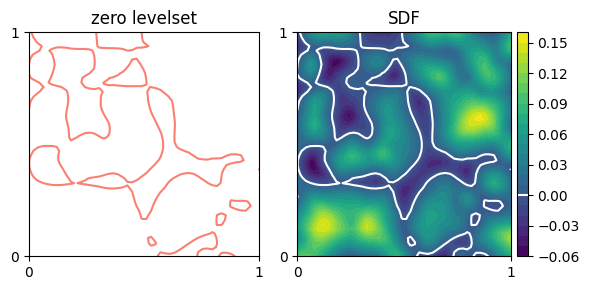

In [10]:
plot2d(lambda x: model(jnp.array([0.4, x[0], x[1]])), ngrid=50)

In [12]:
def normalize(v):
    return v / jnp.linalg.norm(v)

def triangle_normal(triangle):
    v1, v2, v3 = triangle
    return normalize(jnp.cross(v2 - v1, v3 - v1))

def vertex_normals(vertices, faces):
    """Computes vertex normals by uniform averaging of triangle normals."""
    triangles = vertices[faces]
    trinormals = jax.vmap(triangle_normal)(triangles)
    normals = jax.ops.segment_sum(trinormals, faces[:,0])
    normals += jax.ops.segment_sum(trinormals, faces[:,1])
    normals += jax.ops.segment_sum(trinormals, faces[:,2])
    normals = jax.vmap(normalize)(normals)
    return normals

In [13]:
loss, model = fit(xs, normals=vertex_normals(vertices, faces), steps=100, cb_every=10, batch_size=1024, 
                  act=softplus, hidden=512, lam=0.1, emb_kwargs={'nmax': 8}, key=key)
fig = plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)
fig

  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 1.10050333
[10] loss: 0.51068348
[20] loss: 0.20763370
[30] loss: 0.16802153
[40] loss: 0.13518830
[50] loss: 0.11698850
[60] loss: 0.11085114
[70] loss: 0.10533119
[80] loss: 0.10097372
[90] loss: 0.09486023
[99] loss: 0.10156294


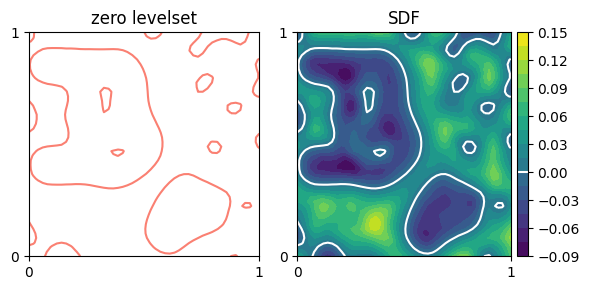

In [14]:
plot2d(lambda x: model(jnp.array([0.4, x[0], x[1]])), ngrid=50)

## What if we regularize stronger?

In [15]:
loss, model = fit(xs, normals=vertex_normals(vertices, faces), steps=100, cb_every=10, batch_size=1024, 
                  act=softplus, hidden=64, lam=1.0, emb_kwargs={'nmax': 4}, key=key)
plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)

  0%|          | 0/100 [00:00<?, ?it/s]

How can we get the benefits of both?
- random idea: perhaps we could use a vanilla IGR network first to approx the surface first and then use multiresolution only close to the surface (e.g. by multiplicative soft thresholding?)
- random idea 2: only render close to points? (e.g. postprocess to only keep surface starting close to points?)
- random idea 3: could we somehow smartly initialize the hashtable?

## Sphere addition

In [15]:
def sdf_sphere(x, radius=0.3, center=jnp.array([0.5, 0.5, 0.5])):
    return jnp.linalg.norm(x - center) - radius

def add_sphere(sdf):
    def sdf_add_sphere(x):
        return sdf(x) + sdf_sphere(x)
    return sdf_add_sphere

plot3d(add_sphere(init_model), ngrid=50)

In [17]:
from sdf_jax.util import dataloader

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.8f}")

def sdf_sphere(x, radius, center):
    return jnp.linalg.norm(x - center) - radius

class AdditiveSphereSDF(tx.Module):
    def __init__(self, hidden: int, radius=0.3, center=jnp.array([0.5, 0.5, 0.5])):
        self.hidden = hidden
        self.radius = radius
        self.center = center
    @tx.compact
    def __call__(self, x):
        net = tx.Sequential(
            HashEmbedding(**emb_kwargs),
            tx.Linear(self.hidden),
            act,
            tx.Linear(self.hidden),
            act,
            tx.Linear(1),
            lambda x: x[0],
        )
        return  sdf_sphere(x, self.radius, self.center) + net(x)

def fit_sphere_addition(
    xs,
    normals=None,
    lam=1.0,
    tau=1.0,
    # module
    hidden=64,
    act=softplus,
    emb_kwargs={"nmax": 32},
    radius=0.3,
    center=np.array([0.5, 0.5, 0.5]),
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    batch_size=128,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = AdditiveSphereSDF(hidden, radius, center).init(key=model_key, inputs=xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    key, data_key = jrandom.split(key, 2)
    for step, (xs_batch, normals_batch) in zip(tqdm(range(steps)), dataloader(xs, normals, batch_size, key=data_key)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs_batch, normals_batch, lam, tau, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(42)
xs = mesh.vertices
print(xs.shape)
loss, model = fit_sphere_addition(
    xs, normals=vertex_normals(mesh.vertices, mesh.faces), 
    steps=100, cb_every=10, batch_size=1024, act=softplus, hidden=512, lam=0.1, key=key,
    radius=0.3, center=mesh.vertices.mean(axis=0),
    emb_kwargs={"nmax": 32, "hashmap_size_log2": 20}
)
fig = plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)
fig

(3225, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

[0] loss: 0.92491990
[10] loss: 0.55649757
[20] loss: 0.41291723
[30] loss: 0.33511218
[40] loss: 0.29943523
[50] loss: 0.23622751
[60] loss: 0.19060862
[70] loss: 0.16456151
[80] loss: 0.15334770
[90] loss: 0.13447073
[99] loss: 0.13326913


## Approach 2: Fit Sphere SDF as "Init"

In [18]:
def sdf_sphere(x, radius, center):
    return jnp.linalg.norm(x - center) - radius

@ft.partial(jax.value_and_grad, has_aux=True)
def sphere_loss_fn(params, model, x, y):
    model = model.merge(params)
    preds = jax.vmap(model)(x)
    loss = jnp.mean(jnp.abs(preds - y) / (jnp.abs(y) + 0.01))
    return loss, model

@jax.jit
def sphere_train_step(model, x, y, optimizer):
    params = model.filter(tx.Parameter)
    (loss, model), grads = sphere_loss_fn(params, model, x, y)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

def fit_sphere(
    xs,
    ys,
    # module
    hidden=64,
    act=jax.nn.relu,
    emb_kwargs={"nmax": 32},
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=1e-4,
    steps=100,
    batch_size=128,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = tx.Sequential(
        HashEmbedding(**emb_kwargs),
        tx.Linear(hidden),
        act,
        tx.Linear(hidden),
        act,
        tx.Linear(1),
        lambda x: x[0]
    ).init(key=model_key, inputs=xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    key, data_key = jrandom.split(key, 2)
    for step, (xs_batch, ys_batch) in zip(tqdm(range(steps)), dataloader(xs, ys, batch_size, key=data_key)):
        loss, model, optimizer = sphere_train_step(model, xs_batch, ys_batch, optimizer)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

xs_sphere = jrandom.uniform(jrandom.PRNGKey(1), (100_000, 3))
ys_sphere = jax.vmap(ft.partial(sdf_sphere, radius=0.3, center=jnp.array([0.5, 0.5, 0.5])))(xs_sphere)
# _, sphere_model = fit_sphere(xs_sphere, ys_sphere, steps=1000, cb_every=200, emb_kwargs={"nmax": 8, "hashmap_size_log2": 20})

  0%|          | 0/1000 [00:00<?, ?it/s]

[0] loss: 0.91040075
[200] loss: 0.14915198
[400] loss: 0.03620742


KeyboardInterrupt: 

In [33]:
plot3d(sphere_model, x_lims=(-0.0, 1.0), ngrid=50)

In [41]:
xs_centered = xs - xs.mean(axis=0) + jnp.array([0.5, 0.5, 0.5])
loss, sphere2_model = fit(xs_centered, normals=vertex_normals(xs_centered, mesh.faces), steps=10, cb_every=1, batch_size=1024, 
                  model=sphere_model, lam=1.0, key=key)
plot3d(sphere2_model, x_lims=(-0.1, 1.1), ngrid=50)

  0%|          | 0/10 [00:00<?, ?it/s]

[0] loss: 0.93076414
[1] loss: 0.77713007
[2] loss: 0.67937106
[3] loss: 0.61245555
[4] loss: 0.53233939
[5] loss: 0.42736828
[6] loss: 0.40063983
[7] loss: 0.41533753
[8] loss: 0.35692272
[9] loss: 0.32106361
[9] loss: 0.32106361


## Approach 3: Low-freq NN + HashEnc displacement

- same idea as additive sphere, but both parts trainable
- might also explore training in two stages (coarse first, then refine)